In [1]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt


from moviepy.editor import*
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import*
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [2]:
seed_constant=27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

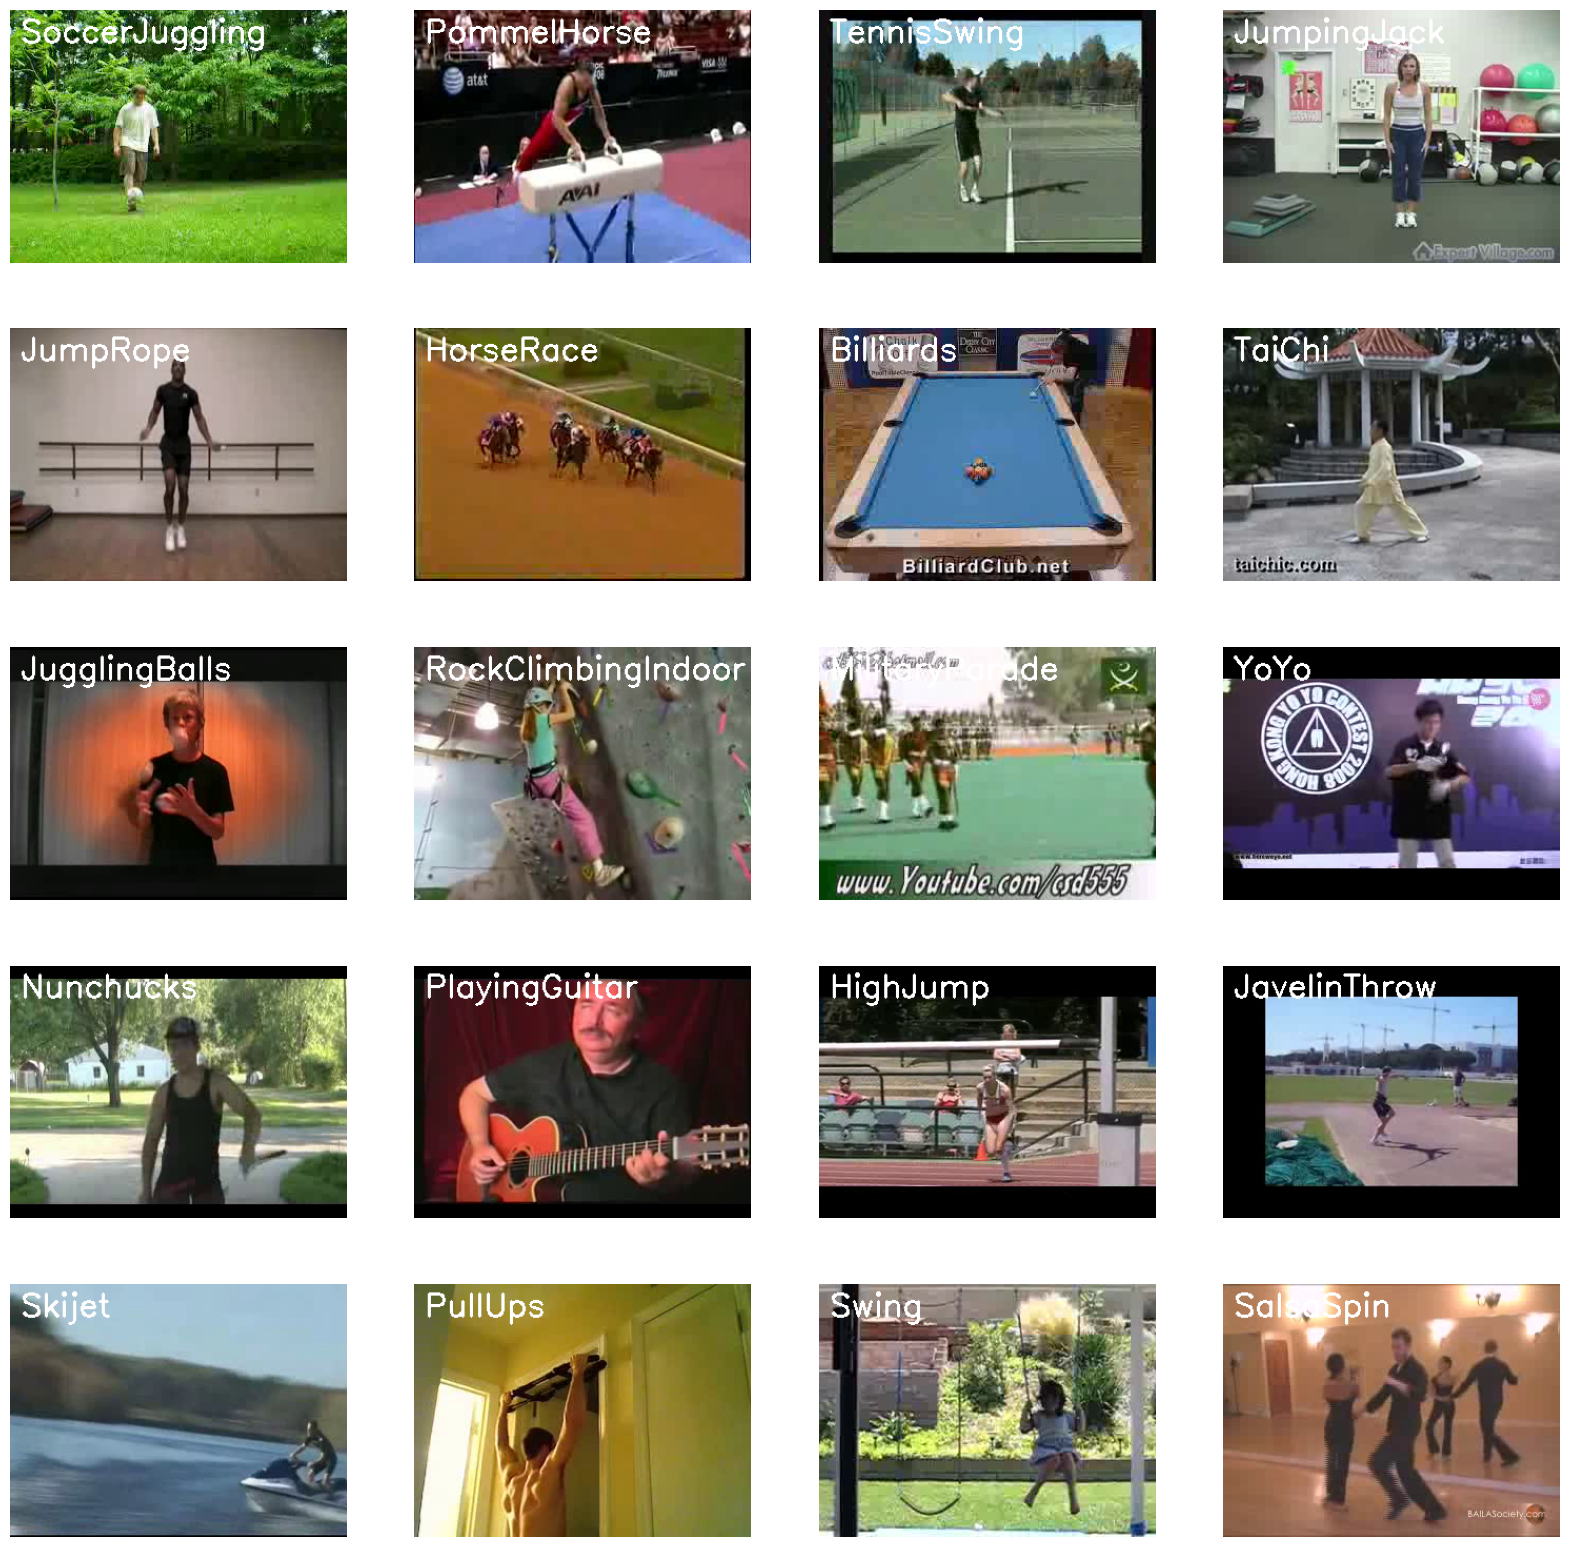

In [3]:
# Create a Matplotlib figure
plt.figure(figsize=(20,20))

# Get the names of the classes in UCF50
all_classes_names = os.listdir('UCF50')

# Generate a list of 20 random classes
#random_range = random.sample(range(len(all_classes_names)),20)

# Generate a list of 3 random classes
random_range = random.sample(range(len(all_classes_names)),20)

# Iterate through all the generated random values
for counter, random_index in enumerate(random_range,1):

  # Class name using Random Index
  selected_class_name = all_classes_names[random_index]

  # Video Files present in randomly selected classes
  video_files_names_list = os.listdir(f'UCF50/{selected_class_name}')

  # Randomly select a video file
  selected_video_file_name = random.choice(video_files_names_list)

  # Videocapture to read the video
  video_reader = cv2.VideoCapture(f'UCF50/{selected_class_name}/{selected_video_file_name}')

  # Read the first frame of the video file
  _, bgr_frame = video_reader.read()

  # Realease the VideoCapture object
  video_reader.release()

  # Convert the frame drom BGR into RGB format
  rgb_frame = cv2.cvtColor(bgr_frame,cv2.COLOR_BGR2RGB)

  # The class name of video frame
  cv2.putText(rgb_frame, selected_class_name,(10,30),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)

  # Display the frame
  plt.subplot(5,4,counter);plt.imshow(rgb_frame);plt.axis('off')


In [4]:
# Specify the height and width of the frame
IMAGE_HEIGHT,IMAGE_WIDTH=64,64

# Define the frames per video
SEQUENCE_LENGTH=20

DATASET_DIR="UCF50"

CLASSES_LIST=["Biking","Diving","GolfSwing","PizzaTossing"]

In [5]:
def frames_extraction(video_path):
  frames_list=[]

  video_reader=cv2.VideoCapture(video_path)

  video_frames_count=int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

  skip_frames_window=max(int(video_frames_count/SEQUENCE_LENGTH),1)

  for frame_counter in range(SEQUENCE_LENGTH):

    video_reader.set(cv2.CAP_PROP_POS_FRAMES,frame_counter*skip_frames_window)

    success,frame=video_reader.read()

    if not success:
      break

    resized_frame=cv2.resize(frame,(IMAGE_HEIGHT,IMAGE_WIDTH))

    normalized_frame=resized_frame/255

    frames_list.append(normalized_frame)

  video_reader.release()

  return frames_list

In [6]:
def create_dataset():

  features=[]
  labels=[]
  video_files_paths=[]

  for class_index,class_name in enumerate(CLASSES_LIST):

    print(f'Extracting Data of Class: {class_name}')

    files_list=os.listdir(os.path.join(DATASET_DIR,class_name))

    for file_name in files_list:

      video_file_path = os.path.join(DATASET_DIR,class_name,file_name)

      frames = frames_extraction(video_file_path)

      if len(frames)==SEQUENCE_LENGTH:

        features.append(frames)
        labels.append(class_index)
        video_files_paths.append(video_file_path)

  features=np.asarray(features)
  labels=np.array(labels)

  return features,labels,video_files_paths

In [7]:
# Create Dataset
features,labels,video_files_paths=create_dataset()

Extracting Data of Class: Biking
Extracting Data of Class: Diving
Extracting Data of Class: GolfSwing
Extracting Data of Class: PizzaTossing


In [8]:
# Into one hot-encoded
one_hot_encoded_labels=to_categorical(labels)

In [9]:
# Split the data into Train and Test
features_train, features_test, labels_train, labels_test = train_test_split(features,one_hot_encoded_labels,test_size=0.25,shuffle=True,random_state=seed_constant)

In [10]:
# We will use ConvLSTM
# We will use sequential model for model construction
def create_convlstm_model():
  model=Sequential()

  # Define model Architecture
  model.add(ConvLSTM2D(filters=4,kernel_size=(3,3),activation='tanh',data_format="channels_last",recurrent_dropout=0.2,return_sequences=True,input_shape=(SEQUENCE_LENGTH,IMAGE_HEIGHT,IMAGE_WIDTH,3)))

  model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters=8,kernel_size=(3,3),activation='tanh',data_format="channels_last",recurrent_dropout=0.2,return_sequences=True))

  model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters=14,kernel_size=(3,3),activation='tanh',data_format="channels_last",recurrent_dropout=0.2,return_sequences=True))

  model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters=16,kernel_size=(3,3),activation='tanh',data_format="channels_last",recurrent_dropout=0.2,return_sequences=True))

  model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last'))
  #model.add(TimeDistributed(Dropout(0.2)))

  model.add(Flatten())

  model.add(Dense(len(CLASSES_LIST),activation="softmax"))

  model.summary()
  return model

In [12]:
# Compile and Train the model
# Create an instance of Early Stopping Callback
early_stopping_callback=EarlyStopping(monitor='val_loss',patience=10,mode='min',restore_best_weights=True)
convlstm_model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=["accuracy"])

# Training the model
convlstm_model_training_history=convlstm_model.fit(x=features_train,y=labels_train,epochs=50,batch_size=4,
                                                   shuffle=True,validation_split=0.2,callbacks=[early_stopping_callback])

Epoch 1/50
83/83 [==============================] - 137s 1s/step - loss: 1.2559 - accuracy: 0.4036 - val_loss: 0.8651 - val_accuracy: 0.5663
Epoch 2/50
83/83 [==============================] - 79s 955ms/step - loss: 0.7495 - accuracy: 0.6988 - val_loss: 0.8788 - val_accuracy: 0.6386
Epoch 3/50
83/83 [==============================] - 79s 953ms/step - loss: 0.5651 - accuracy: 0.7952 - val_loss: 0.4919 - val_accuracy: 0.8675
Epoch 4/50
83/83 [==============================] - 80s 959ms/step - loss: 0.4397 - accuracy: 0.8434 - val_loss: 0.5454 - val_accuracy: 0.8193
Epoch 5/50
83/83 [==============================] - 79s 953ms/step - loss: 0.3334 - accuracy: 0.8765 - val_loss: 0.4751 - val_accuracy: 0.8675
Epoch 6/50
83/83 [==============================] - 74s 892ms/step - loss: 0.2260 - accuracy: 0.9187 - val_loss: 0.5651 - val_accuracy: 0.7711
Epoch 7/50
83/83 [==============================] - 79s 959ms/step - loss: 0.1976 - accuracy: 0.9277 - val_loss: 0.5296 - val_accuracy: 0.7952
E

In [13]:
# Evaluate the model accuracy
model_evaluation_history=convlstm_model.evaluate(features_test,labels_test)

5/5 [==============================] - 6s 1s/step - loss: 0.5135 - accuracy: 0.8921


In [14]:
# Plotting model accuracy
def plot_metric(model_training_history,metric_name_1,metric_name_2,plot_name):

  metric_value_1=model_training_history.history[metric_name_1]
  metric_value_2=model_training_history.history[metric_name_2]

  epochs=range(len(metric_value_1))

  plt.plot(epochs,metric_value_1,'blue',label=metric_name_1)
  plt.plot(epochs,metric_value_2,'red',label=metric_name_2)

  plt.title(str(plot_name))
  plt.legend()

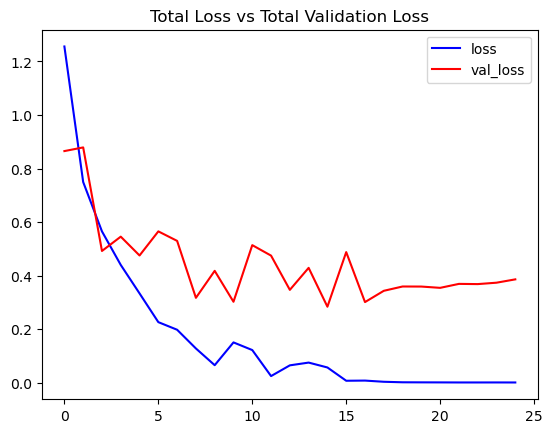

In [15]:
# Visuaize the training and loss metrices
plot_metric(convlstm_model_training_history,'loss','val_loss','Total Loss vs Total Validation Loss')

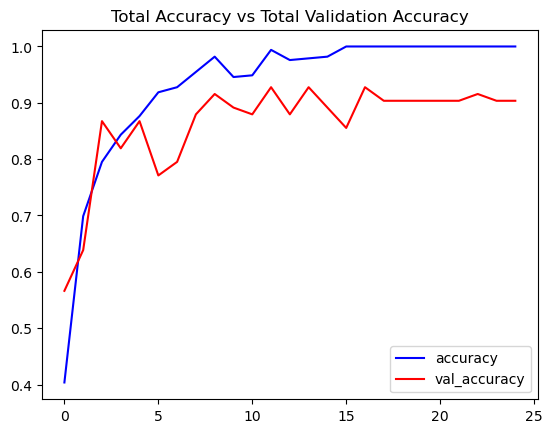

In [16]:
# Visuaize the training and validation accuracy metrices
plot_metric(convlstm_model_training_history,'accuracy','val_accuracy','Total Accuracy vs Total Validation Accuracy')

In [17]:
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
# Assuming model_evaluation_history is a list containing [loss, accuracy]
loss, accuracy = model_evaluation_history

# Predictions can be obtained using your model, assuming your model is named 'convlstm_model'
predictions = convlstm_model.predict(features_test)

# Converting predictions to binary classes if needed
binary_predictions = (predictions > 0.5).astype(int)

# Convert binary_predictions and labels_test to the appropriate format if necessary
# Assuming they are in the shape (samples, num_classes)

# Calculate multilabel confusion matrix
multilabel_conf_matrix = multilabel_confusion_matrix(labels_test, binary_predictions)

# Calculate precision, recall, and f1 score for each label
precisions = precision_score(labels_test, binary_predictions, average='micro')
recalls = recall_score(labels_test, binary_predictions, average='micro')
f1_scores = f1_score(labels_test, binary_predictions, average='micro')

# Calculate accuracy (accuracy_score can be directly used)
accuracy = accuracy_score(labels_test, binary_predictions)

print("Multilabel Confusion Matrix:")
print(multilabel_conf_matrix)
print("Precision (Micro):", precisions)
print("Recall (Micro):", recalls)
print("F1 Score (Micro):", f1_scores)
print("Accuracy:", accuracy)

5/5 [==============================] - 6s 1s/step
Multilabel Confusion Matrix:
[[[ 91  11]
  [  4  33]]

 [[ 91   0]
  [  3  45]]

 [[111   0]
  [  3  25]]

 [[109   4]
  [  5  21]]]
Precision (Micro): 0.8920863309352518
Recall (Micro): 0.8920863309352518
F1 Score (Micro): 0.8920863309352518
Accuracy: 0.8920863309352518


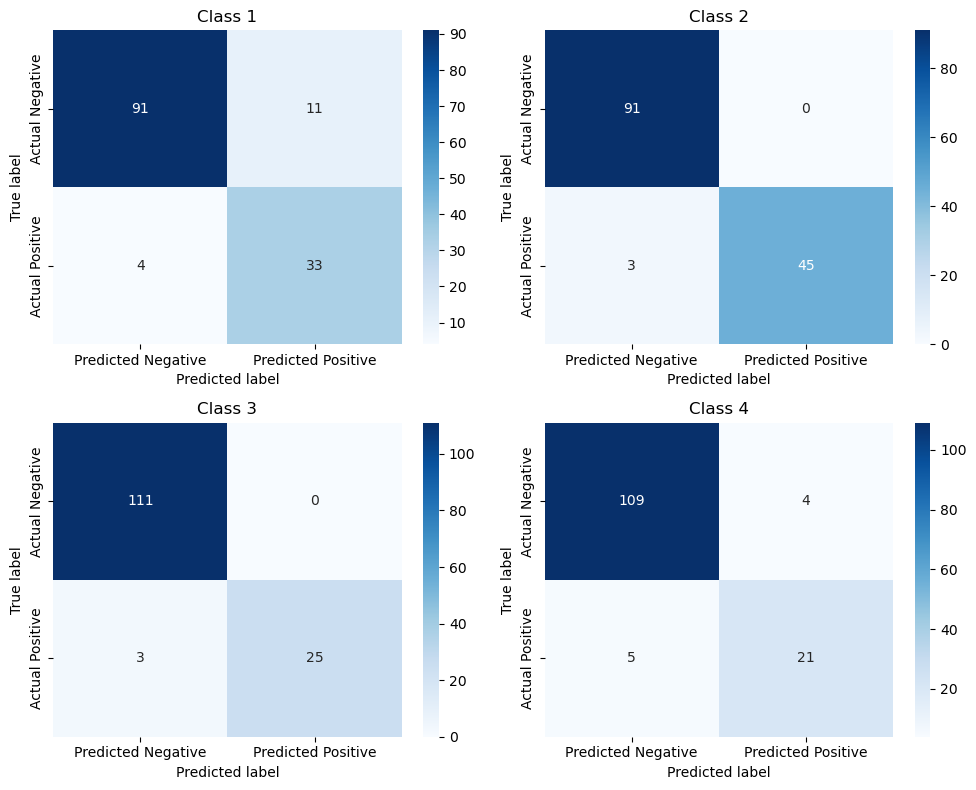

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the multilabel confusion matrix
conf_matrix = np.array([[[91,  11], [ 4, 33]],
                        [[91,  0], [3, 45]],
                        [[111, 0], [ 3, 25]],
                        [[109,  4], [5, 21]]])

# Define class names
class_names = ['Class 1', 'Class 2', 'Class 3', 'Class 4']

# Plot the heatmap
plt.figure(figsize=(10, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    sns.heatmap(conf_matrix[i], annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], 
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title(class_names[i])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
plt.tight_layout()
plt.show()

In [19]:
# Save the model for future use
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

model_file_name = 'convlstm_model_89.h5'  # Provide a static file name

convlstm_model.save(model_file_name)

In [11]:
%%writefile trail.py
import streamlit as st
from pytube import YouTube
import cv2
import numpy as np
from collections import deque
import os
import base64
from moviepy.editor import VideoFileClip
from keras.models import load_model

# Load the model
model_file_path = "C:/Users/veeri/OneDrive - Lovely Professional University/Desktop/Final Project/convlstm_model_89.h5"  # Change this path accordingly
convlstm_model = load_model(model_file_path)

# Define constants
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
SEQUENCE_LENGTH = 20
CLASSES_LIST = ["Biking","Diving","GolfSwing","PizzaTossing"]

def download_youtube_video(youtube_url, output_directory):
    yt = YouTube(youtube_url)
    stream = yt.streams.get_highest_resolution()
    output_file_path = os.path.join(output_directory, f"{yt.title}.mp4")
    stream.download(output_directory)
    return output_file_path, yt.title

def perform_action_recognition(video_file_path, output_file_path):
    video_reader = cv2.VideoCapture(video_file_path)

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc(*'mp4v'),
                                   int(video_reader.get(cv2.CAP_PROP_FPS)), (original_video_width, original_video_height))

    frames_queue = deque(maxlen=SEQUENCE_LENGTH)

    while video_reader.isOpened():
        ok, frame = video_reader.read()

        if not ok:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:
            # Perform action recognition
            predicted_labels_probabilities = convlstm_model.predict(np.expand_dims(frames_queue, axis=0))[0]
            predicted_label = np.argmax(predicted_labels_probabilities)
            predicted_class_name = CLASSES_LIST[predicted_label]

            # Draw predicted class name on frame
            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            # Draw predicted class name on frame with black background box
            text_size = cv2.getTextSize(predicted_class_name, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0]
            text_x, text_y = 10, 30  # Position of the text
            padding = 5  # Padding around the text
            box_coords = ((text_x, text_y + padding), (text_x + text_size[0] + padding * 2, text_y - text_size[1] - padding))

            # Draw the black background box
            cv2.rectangle(frame, box_coords[0], box_coords[1], (0, 0, 0), -1)

            # Draw the predicted class name on the frame
            cv2.putText(frame, predicted_class_name, (text_x + padding, text_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        video_writer.write(frame)

    video_reader.release()
    video_writer.release()

    return output_file_path

def get_binary_file_downloader_html(file_path, title="Download File"):
    with open(file_path, "rb") as f:
        video_bytes = f.read()
    b64 = base64.b64encode(video_bytes).decode()
    file_href = f'<a href="data:file/mp4;base64,{b64}" download="{os.path.basename(file_path)}">{title}</a>'
    return file_href

def main():
    st.title("Human Activity Prediction")
    add_selectbox = st.sidebar.selectbox("How would you like to upload a video?", ("YouTube URL", "Local Device"))
    # Overview of the project
    st.header("Project Overview")
    st.write("""
        This project aims to predict human activity from videos using machine learning techniques.
        We utilize a convolutional LSTM model to recognize various activities such as Biking, Diving, Golf Swing, and Pizza Tossing.
        The model is trained on a dataset of labeled videos and can predict the activity shown in a given video clip.
    """)

    # Image examples
    st.header("Examples of Activities")
    #st.image("biking.jpg", caption="Biking", use_column_width=True)
    #st.image("diving.jpg", caption="Diving", use_column_width=True)
    #st.image("golf_swing.jpg", caption="Golf Swing", use_column_width=True)
    #st.image("pizza_tossing.jpg", caption="Pizza Tossing", use_column_width=True)

    if add_selectbox == "YouTube URL":
        youtube_url = st.text_input("Enter the YouTube URL:")
        if youtube_url:
            st.write("You entered:", youtube_url)
            if st.button("Download YouTube Video"):
                test_videos_directory = 'test_videos'
                os.makedirs(test_videos_directory, exist_ok=True)
                video_file_path, video_title = download_youtube_video(youtube_url, test_videos_directory)
                st.success(f"Download complete! Video saved as: {video_title}.mp4")

                output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
                output_video_file_path = perform_action_recognition(video_file_path, output_video_file_path)

                st.success("Prediction complete! You can download the output video below.")
                st.markdown(get_binary_file_downloader_html(output_video_file_path, "Download Predicted Video"), unsafe_allow_html=True)
                
    elif add_selectbox == "Local Device":
        uploaded_file = st.file_uploader("Upload a video", type=['mp4'])
        if uploaded_file is not None:
            test_videos_directory = 'test_videos'
            os.makedirs(test_videos_directory, exist_ok=True)
            video_file_path = os.path.join(test_videos_directory, uploaded_file.name)
            with open(video_file_path, "wb") as f:
                f.write(uploaded_file.read())
            st.success(f"You uploaded: {uploaded_file.name}")

            output_video_file_path = f'{test_videos_directory}/{uploaded_file.name}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
            output_video_file_path = perform_action_recognition(video_file_path, output_video_file_path)

            st.success("Prediction complete! You can download the output video below.")
            st.markdown(get_binary_file_downloader_html(output_video_file_path, "Download Predicted Video"), unsafe_allow_html=True)

if __name__ == "__main__":
    main()

Overwriting trail.py


In [8]:
!streamlit run trail.py --server.enableXsrfProtection false

^C


In [2]:
!streamlit run cam.py --server.enableXsrfProtection false

^C


In [14]:
%%writefile trail.py
import streamlit as st
from pytube import YouTube
import cv2
import numpy as np
from collections import deque
import os
import base64
from moviepy.editor import VideoFileClip
from keras.models import load_model

# Load the model
model_file_path = "C:/Users/veeri/OneDrive - Lovely Professional University/Desktop/Final Project/convlstm_model_89.h5"  # Change this path accordingly
convlstm_model = load_model(model_file_path)

# Define constants
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
SEQUENCE_LENGTH = 20
CLASSES_LIST = ["Biking","Diving","GolfSwing","PizzaTossing"]

def download_youtube_video(youtube_url, output_directory):
    yt = YouTube(youtube_url)
    stream = yt.streams.get_highest_resolution()
    output_file_path = os.path.join(output_directory, f"{yt.title}.mp4")
    stream.download(output_directory)
    return output_file_path, yt.title

def perform_action_recognition(video_file_path, output_file_path):
    video_reader = cv2.VideoCapture(video_file_path)

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc(*'mp4v'),
                                   int(video_reader.get(cv2.CAP_PROP_FPS)), (original_video_width, original_video_height))

    frames_queue = deque(maxlen=SEQUENCE_LENGTH)

    while video_reader.isOpened():
        ok, frame = video_reader.read()

        if not ok:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:
            # Perform action recognition
            predicted_labels_probabilities = convlstm_model.predict(np.expand_dims(frames_queue, axis=0))[0]
            predicted_label = np.argmax(predicted_labels_probabilities)
            predicted_class_name = CLASSES_LIST[predicted_label]

            # Draw predicted class name on frame
            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            # Draw predicted class name on frame with black background box
            text_size = cv2.getTextSize(predicted_class_name, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0]
            text_x, text_y = 10, 30  # Position of the text
            padding = 5  # Padding around the text
            box_coords = ((text_x, text_y + padding), (text_x + text_size[0] + padding * 2, text_y - text_size[1] - padding))

            # Draw the black background box
            cv2.rectangle(frame, box_coords[0], box_coords[1], (0, 0, 0), -1)

            # Draw the predicted class name on the frame
            cv2.putText(frame, predicted_class_name, (text_x + padding, text_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        video_writer.write(frame)

    video_reader.release()
    video_writer.release()

    return output_file_path

def get_binary_file_downloader_html(file_path, title="Download File"):
    with open(file_path, "rb") as f:
        video_bytes = f.read()
    b64 = base64.b64encode(video_bytes).decode()
    file_href = f'<a href="data:file/mp4;base64,{b64}" download="{os.path.basename(file_path)}">{title}</a>'
    return file_href

def perform_action_recognition_from_camera(frame, frames_queue):
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:
            # Perform action recognition (replace this with your actual model prediction)
            # Dummy prediction for demonstration
            predicted_labels_probabilities = convlstm_model.predict(np.expand_dims(frames_queue, axis=0))[0]
            predicted_label = np.random.randint(len(CLASSES_LIST))
            predicted_class_name = CLASSES_LIST[predicted_label]

            # Draw predicted class name on frame
            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            # Draw predicted class name on frame with black background box
            text_size = cv2.getTextSize(predicted_class_name, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0]
            text_x, text_y = 10, 30  # Position of the text
            padding = 5  # Padding around the text
            box_coords = ((text_x, text_y + padding), (text_x + text_size[0] + padding * 2, text_y - text_size[1] - padding))

            # Draw the black background box
            cv2.rectangle(frame, box_coords[0], box_coords[1], (0, 0, 0), -1)

            # Draw the predicted class name on the frame
            cv2.putText(frame, predicted_class_name, (text_x + padding, text_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        return frame
        
def main():
    st.title("Human Activity Prediction")
    add_selectbox = st.sidebar.selectbox("How would you like to upload a video?", ("YouTube URL", "Local Device", "Live Camera"))

    if add_selectbox == "YouTube URL":
        youtube_url = st.text_input("Enter the YouTube URL:")
        if youtube_url:
            st.write("You entered:", youtube_url)
            if st.button("Download YouTube Video"):
                test_videos_directory = 'test_videos'
                os.makedirs(test_videos_directory, exist_ok=True)
                video_file_path, video_title = download_youtube_video(youtube_url, test_videos_directory)
                st.success(f"Download complete! Video saved as: {video_title}.mp4")

                output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
                output_video_file_path = perform_action_recognition(video_file_path, output_video_file_path)

                st.success("Prediction complete! You can download the output video below.")
                st.markdown(get_binary_file_downloader_html(output_video_file_path, "Download Predicted Video"), unsafe_allow_html=True)
                
    elif add_selectbox == "Local Device":
        uploaded_file = st.file_uploader("Upload a video", type=['mp4'])
        if uploaded_file is not None:
            test_videos_directory = 'test_videos'
            os.makedirs(test_videos_directory, exist_ok=True)
            video_file_path = os.path.join(test_videos_directory, uploaded_file.name)
            with open(video_file_path, "wb") as f:
                f.write(uploaded_file.read())
            st.success(f"You uploaded: {uploaded_file.name}")

            output_video_file_path = f'{test_videos_directory}/{uploaded_file.name}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
            output_video_file_path = perform_action_recognition(video_file_path, output_video_file_path)

            st.success("Prediction complete! You can download the output video below.")
            st.markdown(get_binary_file_downloader_html(output_video_file_path, "Download Predicted Video"), unsafe_allow_html=True)

    elif add_selectbox == "Live Camera":
        st.write("Click the button below to start the camera and perform activity detection.")
        if st.button("Predict from Camera"):
            cap = cv2.VideoCapture(0)  # Open the default camera (0) on your laptop
            frames_queue = []

            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break

                processed_frame = perform_action_recognition_from_camera(frame, frames_queue)

                cv2.imshow('Human Activity Prediction', processed_frame)

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

            cap.release()
            cv2.destroyAllWindows()


if __name__ == "__main__":
    main()

Overwriting trail.py


In [1]:
%%writefile cam.py
import streamlit as st
import cv2
import numpy as np
from keras.models import load_model

# Define constants
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
SEQUENCE_LENGTH = 20
CLASSES_LIST = ["Biking", "Diving", "GolfSwing", "PizzaTossing"]
model_file_path = "C:/Users/veeri/OneDrive - Lovely Professional University/Desktop/Final Project/convlstm_model_89.h5"  # Change this path accordingly
convlstm_model = load_model(model_file_path)

def perform_action_recognition_on_frame(frame, frames_queue):
    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
    normalized_frame = resized_frame / 255
    frames_queue.append(normalized_frame)

    if len(frames_queue) == SEQUENCE_LENGTH:
        # Perform action recognition (replace this with your actual model prediction)
        # Dummy prediction for demonstration
        predicted_labels_probabilities = convlstm_model.predict(np.expand_dims(frames_queue, axis=0))[0]
        predicted_label = np.random.randint(len(CLASSES_LIST))
        predicted_class_name = CLASSES_LIST[predicted_label]

        # Draw predicted class name on frame
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        # Draw predicted class name on frame with black background box
        text_size = cv2.getTextSize(predicted_class_name, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0]
        text_x, text_y = 10, 30  # Position of the text
        padding = 5  # Padding around the text
        box_coords = ((text_x, text_y + padding), (text_x + text_size[0] + padding * 2, text_y - text_size[1] - padding))

        # Draw the black background box
        cv2.rectangle(frame, box_coords[0], box_coords[1], (0, 0, 0), -1)

        # Draw the predicted class name on the frame
        cv2.putText(frame, predicted_class_name, (text_x + padding, text_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    return frame

def main():
    st.title("Live Camera Detection")
    st.write("Click the button below to start the camera and perform activity detection.")

    if st.button("Predict from Camera"):
        cap = cv2.VideoCapture(0)  # Open the default camera (0) on your laptop
        frames_queue = []

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            processed_frame = perform_action_recognition_on_frame(frame, frames_queue)

            cv2.imshow('Human Activity Prediction', processed_frame)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()

if __name__ == "__main__":
    main()

Overwriting cam.py


In [3]:
%%writefile trail.py
import streamlit as st
from pytube import YouTube
import cv2
import numpy as np
from collections import deque
import os
import base64
from moviepy.editor import VideoFileClip
from keras.models import load_model

# Load the model
model_file_path = "C:/Users/veeri/OneDrive - Lovely Professional University/Desktop/Final Project/convlstm_model_89.h5"  # Change this path accordingly
convlstm_model = load_model(model_file_path)

# Define constants
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
SEQUENCE_LENGTH = 20
CLASSES_LIST = ["Biking","Diving","GolfSwing","PizzaTossing"]

def download_youtube_video(youtube_url, output_directory):
    yt = YouTube(youtube_url)
    stream = yt.streams.get_highest_resolution()
    output_file_path = os.path.join(output_directory, f"{yt.title}.mp4")
    stream.download(output_directory)
    return output_file_path, yt.title

def perform_action_recognition(video_file_path, output_file_path):
    video_reader = cv2.VideoCapture(video_file_path)

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc(*'mp4v'),
                                   int(video_reader.get(cv2.CAP_PROP_FPS)), (original_video_width, original_video_height))

    frames_queue = deque(maxlen=SEQUENCE_LENGTH)

    while video_reader.isOpened():
        ok, frame = video_reader.read()

        if not ok:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:
            # Perform action recognition
            predicted_labels_probabilities = convlstm_model.predict(np.expand_dims(frames_queue, axis=0))[0]
            predicted_label = np.argmax(predicted_labels_probabilities)
            predicted_class_name = CLASSES_LIST[predicted_label]

            # Draw predicted class name on frame
            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            # Draw predicted class name on frame with black background box
            text_size = cv2.getTextSize(predicted_class_name, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0]
            text_x, text_y = 10, 30  # Position of the text
            padding = 5  # Padding around the text
            box_coords = ((text_x, text_y + padding), (text_x + text_size[0] + padding * 2, text_y - text_size[1] - padding))

            # Draw the black background box
            cv2.rectangle(frame, box_coords[0], box_coords[1], (0, 0, 0), -1)

            # Draw the predicted class name on the frame
            cv2.putText(frame, predicted_class_name, (text_x + padding, text_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        video_writer.write(frame)

    video_reader.release()
    video_writer.release()

    return output_file_path

def get_binary_file_downloader_html(file_path, title="Download File"):
    with open(file_path, "rb") as f:
        video_bytes = f.read()
    b64 = base64.b64encode(video_bytes).decode()
    file_href = f'<a href="data:file/mp4;base64,{b64}" download="{os.path.basename(file_path)}">{title}</a>'
    return file_href

def main():
    st.title("Human Activity Prediction")
    add_selectbox = st.sidebar.selectbox("How would you like to upload a video?", ("YouTube URL", "Local Device", "Live Camera"))

    if add_selectbox == "YouTube URL":
        youtube_url = st.text_input("Enter the YouTube URL:")
        if youtube_url:
            st.write("You entered:", youtube_url)
            if st.button("Download YouTube Video"):
                test_videos_directory = 'test_videos'
                os.makedirs(test_videos_directory, exist_ok=True)
                video_file_path, video_title = download_youtube_video(youtube_url, test_videos_directory)
                st.success(f"Download complete! Video saved as: {video_title}.mp4")

                output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
                output_video_file_path = perform_action_recognition(video_file_path, output_video_file_path)

                st.success("Prediction complete! You can download the output video below.")
                st.markdown(get_binary_file_downloader_html(output_video_file_path, "Download Predicted Video"), unsafe_allow_html=True)
                
    elif add_selectbox == "Local Device":
        uploaded_file = st.file_uploader("Upload a video", type=['mp4'])
        if uploaded_file is not None:
            test_videos_directory = 'test_videos'
            os.makedirs(test_videos_directory, exist_ok=True)
            video_file_path = os.path.join(test_videos_directory, uploaded_file.name)
            with open(video_file_path, "wb") as f:
                f.write(uploaded_file.read())
            st.success(f"You uploaded: {uploaded_file.name}")

            output_video_file_path = f'{test_videos_directory}/{uploaded_file.name}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
            output_video_file_path = perform_action_recognition(video_file_path, output_video_file_path)

            st.success("Prediction complete! You can download the output video below.")
            st.markdown(get_binary_file_downloader_html(output_video_file_path, "Download Predicted Video"), unsafe_allow_html=True)

    elif add_selectbox == "Live Camera":
        st.write("Click the button below to start the camera and perform activity detection.")

        if st.button("Predict from Camera"):
            cap = cv2.VideoCapture(0)  # Open the default camera (0) on your laptop
            frames_queue = []

            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break

                resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
                normalized_frame = resized_frame / 255
                frames_queue.append(normalized_frame)

                if len(frames_queue) == SEQUENCE_LENGTH:
                    # Perform action recognition (replace this with your actual model prediction)
                    # Dummy prediction for demonstration
                    predicted_labels_probabilities = convlstm_model.predict(np.expand_dims(frames_queue, axis=0))[0]
                    predicted_label = np.random.randint(len(CLASSES_LIST))
                    predicted_class_name = CLASSES_LIST[predicted_label]

                    # Draw predicted class name on frame
                    cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                    # Draw predicted class name on
if __name__ == "__main__":
    main()

Overwriting trail.py


In [1]:
%%writefile trail.py
import streamlit as st
from pytube import YouTube
import cv2
import numpy as np
from collections import deque
import os
import base64
from moviepy.editor import VideoFileClip
from keras.models import load_model

# Load the model
model_file_path = "C:/Users/veeri/OneDrive - Lovely Professional University/Desktop/Final Project/convlstm_model_89.h5"  # Change this path accordingly
convlstm_model = load_model(model_file_path)

# Define constants
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
SEQUENCE_LENGTH = 20
CLASSES_LIST = ["Biking","Diving","GolfSwing","PizzaTossing"]

def download_youtube_video(youtube_url, output_directory):
    yt = YouTube(youtube_url)
    stream = yt.streams.get_highest_resolution()
    output_file_path = os.path.join(output_directory, f"{yt.title}.mp4")
    stream.download(output_directory)
    return output_file_path, yt.title

def perform_action_recognition(video_file_path, output_file_path):
    video_reader = cv2.VideoCapture(video_file_path)

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc(*'mp4v'),
                                   int(video_reader.get(cv2.CAP_PROP_FPS)), (original_video_width, original_video_height))

    frames_queue = deque(maxlen=SEQUENCE_LENGTH)

    while video_reader.isOpened():
        ok, frame = video_reader.read()

        if not ok:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:
            # Perform action recognition
            predicted_labels_probabilities = convlstm_model.predict(np.expand_dims(frames_queue, axis=0))[0]
            predicted_label = np.argmax(predicted_labels_probabilities)
            predicted_class_name = CLASSES_LIST[predicted_label]

            # Draw predicted class name on frame
            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            # Draw predicted class name on frame with black background box
            text_size = cv2.getTextSize(predicted_class_name, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0]
            text_x, text_y = 10, 30  # Position of the text
            padding = 5  # Padding around the text
            box_coords = ((text_x, text_y + padding), (text_x + text_size[0] + padding * 2, text_y - text_size[1] - padding))

            # Draw the black background box
            cv2.rectangle(frame, box_coords[0], box_coords[1], (0, 0, 0), -1)

            # Draw the predicted class name on the frame
            cv2.putText(frame, predicted_class_name, (text_x + padding, text_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        video_writer.write(frame)

    video_reader.release()
    video_writer.release()

    return output_file_path

def get_binary_file_downloader_html(file_path, title="Download File"):
    with open(file_path, "rb") as f:
        video_bytes = f.read()
    b64 = base64.b64encode(video_bytes).decode()
    file_href = f'<a href="data:file/mp4;base64,{b64}" download="{os.path.basename(file_path)}">{title}</a>'
    return file_href

def overview_page():
    st.title("Human Activity Prediction - Overview")

    st.header("Project Overview")
    st.write("""
        This project aims to predict human activity from videos using machine learning techniques.
        We utilize a convolutional LSTM model to recognize various activities such as Biking, Diving, Golf Swing, and Pizza Tossing.
        The model is trained on a dataset of labeled videos and can predict the activity shown in a given video clip.
    """)

    st.header("Examples of Activities")
    st.image("biking.jpg", caption="Biking", use_column_width=True)
    st.image("diving.jpg", caption="Diving", use_column_width=True)
    st.image("golf_swing.jpg", caption="Golf Swing", use_column_width=True)
    st.image("pizza_tossing.jpg", caption="Pizza Tossing", use_column_width=True)

def video_sources_page():
    st.title("Select Video Source")

    st.header("Options")
    st.write("Choose from the following video sources:")

    if st.button("YouTube URL"):
        youtube_url = st.text_input("Enter the YouTube URL:")
        if youtube_url:
            st.write("You entered:", youtube_url)
            if st.button("Download YouTube Video"):
                test_videos_directory = 'test_videos'
                os.makedirs(test_videos_directory, exist_ok=True)
                video_file_path, video_title = download_youtube_video(youtube_url, test_videos_directory)
                st.success(f"Download complete! Video saved as: {video_title}.mp4")

                output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
                output_video_file_path = perform_action_recognition(video_file_path, output_video_file_path)

                st.success("Prediction complete! You can download the output video below.")
                st.markdown(get_binary_file_downloader_html(output_video_file_path, "Download Predicted Video"), unsafe_allow_html=True)
                
    if st.button("Local Device"):
        uploaded_file = st.file_uploader("Upload a video", type=['mp4'])
        if uploaded_file is not None:
            test_videos_directory = 'test_videos'
            os.makedirs(test_videos_directory, exist_ok=True)
            video_file_path = os.path.join(test_videos_directory, uploaded_file.name)
            with open(video_file_path, "wb") as f:
                f.write(uploaded_file.read())
            st.success(f"You uploaded: {uploaded_file.name}")

            output_video_file_path = f'{test_videos_directory}/{uploaded_file.name}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
            output_video_file_path = perform_action_recognition(video_file_path, output_video_file_path)

            st.success("Prediction complete! You can download the output video below.")
            st.markdown(get_binary_file_downloader_html(output_video_file_path, "Download Predicted Video"), unsafe_allow_html=True)

    if st.button("Live Camera"):
        st.write("Click the button below to start the camera and perform activity detection.")

        if st.button("Predict from Camera"):
            cap = cv2.VideoCapture(0)  # Open the default camera (0) on your laptop
            frames_queue = []

            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break

                resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
                normalized_frame = resized_frame / 255
                frames_queue.append(normalized_frame)

                if len(frames_queue) == SEQUENCE_LENGTH:
                    # Perform action recognition (replace this with your actual model prediction)
                    # Dummy prediction for demonstration
                    predicted_labels_probabilities = convlstm_model.predict(np.expand_dims(frames_queue, axis=0))[0]
                    predicted_label = np.random.randint(len(CLASSES_LIST))
                    predicted_class_name = CLASSES_LIST[predicted_label]

                    # Draw predicted class name on frame
                    cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                    # Draw predicted class name on
            

def main():
    st.title("Human Activity Prediction")

    st.sidebar.title("Navigation")

    pages = {
        "Overview": overview_page,
        "Video Sources": video_sources_page
    }

    selection = st.sidebar.radio("Go to", list(pages.keys()))

    if selection in pages:
        pages[selection]()

if __name__ == "__main__":
    main()

Overwriting trail.py


In [1]:
%%writefile trail.py
import streamlit as st
from pytube import YouTube
import cv2
import numpy as np
from collections import deque
import os
import base64
from moviepy.editor import VideoFileClip
from keras.models import load_model

# Load the model
model_file_path = "C:/Users/veeri/OneDrive - Lovely Professional University/Desktop/Final Project/convlstm_model_89.h5"  # Change this path accordingly
convlstm_model = load_model(model_file_path)

# Define constants
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
SEQUENCE_LENGTH = 20
CLASSES_LIST = ["Biking","Diving","GolfSwing","PizzaTossing"]

def download_youtube_video(youtube_url, output_directory):
    yt = YouTube(youtube_url)
    stream = yt.streams.get_highest_resolution()
    output_file_path = os.path.join(output_directory, f"{yt.title}.mp4")
    stream.download(output_directory)
    return output_file_path, yt.title

def perform_action_recognition(video_file_path, output_file_path):
    video_reader = cv2.VideoCapture(video_file_path)

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc(*'mp4v'),
                                   int(video_reader.get(cv2.CAP_PROP_FPS)), (original_video_width, original_video_height))

    frames_queue = deque(maxlen=SEQUENCE_LENGTH)

    while video_reader.isOpened():
        ok, frame = video_reader.read()

        if not ok:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:
            # Perform action recognition
            predicted_labels_probabilities = convlstm_model.predict(np.expand_dims(frames_queue, axis=0))[0]
            predicted_label = np.argmax(predicted_labels_probabilities)
            predicted_class_name = CLASSES_LIST[predicted_label]

            # Draw predicted class name on frame
            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            # Draw predicted class name on frame with black background box
            text_size = cv2.getTextSize(predicted_class_name, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0]
            text_x, text_y = 10, 30  # Position of the text
            padding = 5  # Padding around the text
            box_coords = ((text_x, text_y + padding), (text_x + text_size[0] + padding * 2, text_y - text_size[1] - padding))

            # Draw the black background box
            cv2.rectangle(frame, box_coords[0], box_coords[1], (0, 0, 0), -1)

            # Draw the predicted class name on the frame
            cv2.putText(frame, predicted_class_name, (text_x + padding, text_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        video_writer.write(frame)

    video_reader.release()
    video_writer.release()

    return output_file_path

def get_binary_file_downloader_html(file_path, title="Download File"):
    with open(file_path, "rb") as f:
        video_bytes = f.read()
    b64 = base64.b64encode(video_bytes).decode()
    file_href = f'<a href="data:file/mp4;base64,{b64}" download="{os.path.basename(file_path)}">{title}</a>'
    return file_href

def perform_action_recognition_from_camera(frame, frames_queue):
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:
            # Perform action recognition (replace this with your actual model prediction)
            # Dummy prediction for demonstration
            predicted_labels_probabilities = convlstm_model.predict(np.expand_dims(frames_queue, axis=0))[0]
            predicted_label = np.random.randint(len(CLASSES_LIST))
            predicted_class_name = CLASSES_LIST[predicted_label]

            # Draw predicted class name on frame
            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            # Draw predicted class name on frame with black background box
            text_size = cv2.getTextSize(predicted_class_name, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0]
            text_x, text_y = 10, 30  # Position of the text
            padding = 5  # Padding around the text
            box_coords = ((text_x, text_y + padding), (text_x + text_size[0] + padding * 2, text_y - text_size[1] - padding))

            # Draw the black background box
            cv2.rectangle(frame, box_coords[0], box_coords[1], (0, 0, 0), -1)

            # Draw the predicted class name on the frame
            cv2.putText(frame, predicted_class_name, (text_x + padding, text_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        return frame
        
def main():
    st.title("Human Activity Prediction")
    agree= st.sidebar.checkbox("Overview of the Project")
    if agree:
        st.title("About")

        st.header("Project Overview")
        st.write("""
        This project aims to predict human activity from videos using machine learning techniques.
        We utilize a convolutional LSTM model to recognize various activities such as Biking, Diving, Golf Swing, and Pizza Tossing.
        The model is trained on a dataset of labeled videos and can predict the activity shown in a given video clip.
        """)
        st.header("Examples")
        a=st.toggle("Biking")
        if a:
            st.image('C:/Users/veeri/Downloads/Biking.jpg', caption='Biking')
        b=st.toggle("Diving")
        if b:
            st.image('C:/Users/veeri/Downloads/Diving.jpg', caption='Diving')
        c=st.toggle("Golf Swing")
        if c:
            st.image('C:/Users/veeri/Downloads/Golf.jpg', caption='Golf Swing')
        d=st.toggle("Pizza Tossing")
        if d:
            st.image('C:/Users/veeri/Downloads/Pizza.jpg', caption='Pizza Tossing')

    add_selectbox = st.sidebar.selectbox("How would you like to upload a video?", ("YouTube URL", "Local Device", "Live Camera"))
    if add_selectbox == "YouTube URL":
        youtube_url = st.text_input("Enter the YouTube URL:")
        if youtube_url:
            st.write("You entered:", youtube_url)
            if st.button("Download YouTube Video"):
                test_videos_directory = 'test_videos'
                os.makedirs(test_videos_directory, exist_ok=True)
                video_file_path, video_title = download_youtube_video(youtube_url, test_videos_directory)
                st.success(f"Download complete! Video saved as: {video_title}.mp4")

                output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
                output_video_file_path = perform_action_recognition(video_file_path, output_video_file_path)

                st.success("Prediction complete! You can download the output video below.")
                st.markdown(get_binary_file_downloader_html(output_video_file_path, "Download Predicted Video"), unsafe_allow_html=True)
                
    elif add_selectbox == "Local Device":
        uploaded_file = st.file_uploader("Upload a video", type=['mp4'])
        if uploaded_file is not None:
            test_videos_directory = 'test_videos'
            os.makedirs(test_videos_directory, exist_ok=True)
            video_file_path = os.path.join(test_videos_directory, uploaded_file.name)
            with open(video_file_path, "wb") as f:
                f.write(uploaded_file.read())
            st.success(f"You uploaded: {uploaded_file.name}")

            output_video_file_path = f'{test_videos_directory}/{uploaded_file.name}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
            output_video_file_path = perform_action_recognition(video_file_path, output_video_file_path)

            st.success("Prediction complete! You can download the output video below.")
            st.markdown(get_binary_file_downloader_html(output_video_file_path, "Download Predicted Video"), unsafe_allow_html=True)

    elif add_selectbox == "Live Camera":
        st.write("Click the button below to start the camera and perform activity detection.")
        if st.button("Predict from Camera"):
            cap = cv2.VideoCapture(0)  # Open the default camera (0) on your laptop
            frames_queue = []

            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break

                processed_frame = perform_action_recognition_from_camera(frame, frames_queue)

                cv2.imshow('Human Activity Prediction', processed_frame)

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

            cap.release()
            cv2.destroyAllWindows()


if __name__ == "__main__":
    main()

Overwriting trail.py


In [2]:
!streamlit run trail.py --server.enableXsrfProtection false

^C


In [4]:
%%writefile trail.py
import streamlit as st
st.image('C:/Users/veeri/Downloads/Screenshot 2024-04-09 154920.png', caption='Sunrise by the mountains')

Overwriting trail.py
